## –í–µ—Ä—Ö–Ω–∏–π –ø—Ä–µ–¥–µ–ª –Ω–∞ $Br ( f_2^{'}(1525) \to e^+ e^- )$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
from pylib.statistics import efficiency_error
from pylib.preprocess import HandlerKSKS
from pylib.radcors import RadCor
import pylib.fit as pyfit
import pylib.ksks as ksks
import iminuit
import seaborn as sns
import awkward as ak

from progressbar import progressbar
import re

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

# Born $\to$ visible cross sections

In [3]:
def born2visible(e_beams : np.array, 
                 cs_born : np.array, threshold: float) -> np.array:
    """
    –í–∏–¥–∏–º—ã–µ —Å–µ—á–µ–Ω–∏—è –∏–∑ –±–æ—Ä–Ω–æ–≤—Å–∫–∏—Ö
    e_beams - —ç–Ω–µ—Ä–≥–∏–∏ –ø—É—á–∫–∞ (–ú—ç–í),
    cs_born - –±–æ—Ä–Ω–æ–≤—Å–∫–∏–µ —Å–µ—á–µ–Ω–∏—è (–Ω–±–Ω),
    threshold - –ø–æ—Ä–æ–≥ —Ä–æ–∂–¥–µ–Ω–∏—è (–ú—ç–í)
    """
    rc = RadCor(e_beams, cs_born, threshold)
    radcors = []
    for e_beam in e_beams:
        radcors.append(
            rc.F_Radcor(e_beam, [], use_efficiency=False)[0]
        )
    return cs_born*radcors

## –í–∏–¥–∏–º–æ–µ —Å–µ—á–µ–Ω–∏–µ $e^+e^- \to \ f \ \to \ K_SK_S$

$$
    \sigma_{born}(s) = \frac{20 \pi}{s} \frac{M_f^2 \Gamma^2 Br(f \to e^+e^-) Br(f \to K \overline{K})}{{(M_f^2 - s)}^2 + M_f^2 \Gamma^2}
$$

$$
    Br(f \to e^+ e^-)_U = \frac{4}{9} \alpha^2 Br(f \to \gamma \gamma)
$$

–≤ —É–Ω–∏—Ç–∞—Ä–Ω–æ–º –ø—Ä–µ–¥–µ–ª–µ (–≤–∑—è–ª –∏–∑ –¥–∏–ø–ª–æ–º–∞ —Ñ–æ—Ä–º—É–ª—ã)

In [4]:
Br_ee_unitary_limit = (4/9)*( ((1/137.04)**2) * 9.5e-7)

def born_ee_f(s, M = 1517.4, W = 86, Br_ee = Br_ee_unitary_limit, Br_f = 0.876):
    """
    –ë–æ—Ä–Ω–æ–≤—Å–∫–æ–µ —Å–µ—á–µ–Ω–∏–µ –ø—Ä–æ—Ü–µ—Å—Å–∞ e+e- -> T -> f (–Ω–±–Ω), 
    T - —Ç–µ–Ω–∑–æ—Ä–Ω—ã–π —Ä–µ–∑–æ–Ω–∞–Ω—Å, f - –∫–æ–Ω–µ—á–Ω–æ–µ —Å–æ—Å—Ç–æ—è–Ω–∏–µ
    M - –º–∞—Å—Å—Å–∞ —Ä–µ–∑–æ–Ω–∞–Ω—Å–∞ (–ú—ç–í/c), W - —à–∏—Ä–∏–Ω–∞ —Ä–µ–∑–æ–Ω–∞–Ω—Å–∞ (–ú—ç–í/c),
    s - –ì—ç–í^2
    """
    s_MeV = s*1e6
    breit_wigner = (M**2)*(W**2)*Br_ee*Br_f/( (M**2 - s_MeV)**2 + (M**2)*(W**2) )
    norm_constant = 0.38938e6 # GeV^2 * nbn
    cs_born = (20*np.pi/s)*breit_wigner*norm_constant
    return cs_born # nbn

In [5]:
df_fksks = pd.DataFrame({'ebeam': np.linspace(550, 950, 250)})
df_fksks['cs_born'] = born_ee_f((df_fksks['ebeam']*2e-3)**2)

In [6]:
df_fksks['cs_vis'] = born2visible(df_fksks['ebeam'], 
                                  df_fksks['cs_born'],
                                 threshold=497.6)

In [7]:
from matplotlib.ticker import EngFormatter

plt.plot(df_fksks['ebeam']*2e-3, df_fksks['cs_born']*1e-9, label='born')
plt.plot(df_fksks['ebeam']*2e-3, df_fksks['cs_vis']*1e-9, label='visible')
formatter0 = EngFormatter(unit='b')
plt.gca().yaxis.set_major_formatter(formatter0)
pys.my_style(r'$e^+e^- \to \ f \ \to \ K_SK_S$', 
             '$\sqrt{s}$, GeV', '$\\sigma$', legend=True);

## –í–∏–¥–∏–º–æ–µ —Å–µ—á–µ–Ω–∏–µ $e^+e^- \ \to \ 2 \pi^+ 2\pi^-$

–ø–æ—Å–∫–æ–ª—å–∫—É –æ—Å–Ω–æ–≤–Ω–æ–π —Ñ–æ–Ω $2 \pi^+ 2\pi^-$, —Ç–æ –µ–≥–æ –Ω–∞–¥–æ –≤—ã—á–∏—Ç–∞—Ç—å –∏ –∑–Ω–∞—Ç—å —Å–µ—á–µ–Ω–∏—è

–±–æ—Ä–Ω–æ–≤—Å–∫–∏–µ —Å–µ—á–µ–Ω–∏—è –≤–∑—è–ª –∏–∑ `cmd3sim` (–Ω–∞—Å–∫–æ–ª—å–∫–æ —è –ø–æ–Ω—è–ª, —Ç–∞–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã BaBar)

In [8]:
df_4pic = pd.read_csv('../csv/ksks/cs_born_4pic.csv', 
                      sep=' ', header=None, index_col=0)
df_4pic[1] /=2
df_4pic.columns = ['ebeam', 'cs_born']
df_4pic = df_4pic.query('(ebeam<950)')

In [9]:
df_4pic['cs_vis'] = born2visible(df_4pic['ebeam'].values, 
                                 df_4pic['cs_born'].values, 
                                 threshold=139.57*2)

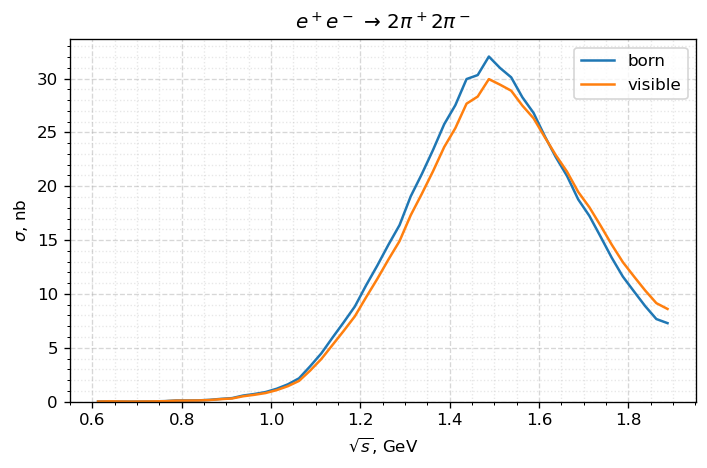

In [10]:
plt.plot(df_4pic['ebeam']*2e-3, df_4pic['cs_born'], label='born');
plt.plot(df_4pic['ebeam']*2e-3, df_4pic['cs_vis'], label='visible');
pys.my_style(r'$e^+e^- \ \to \ 2 \pi^+ 2\pi^-$', 
             '$\sqrt{s}$, GeV', '$\sigma$, nb', 
             ylim=(0,None), legend=True)

# MC analysis

–ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É—é —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –≤ –ú–æ–Ω—Ç–µ-–ö–∞—Ä–ª–æ $e^+ e^- \to f \to K_S K_S$

In [11]:
tr_mc = uproot.open('/outstage/lukinp/sim/tr_ph_f2ksks_1.8GeV.root')['tr_ph']

In [12]:
data_mc = tr_mc.arrays(['nt', 'nks'], library='np')
fig, ax = plt.subplots(1, 2)
t_mc, nt_mc = np.unique(data_mc['nt'], return_counts=True)
ax[0].bar(t_mc, nt_mc)
ax[0].set(title='nt')
t_mc, nt_mc = np.unique(data_mc['nks'], return_counts=True)
ax[1].bar(t_mc, nt_mc)
ax[1].set(title='nks')
plt.tight_layout()

—É –º–µ–Ω—è —É—Å–ª–æ–≤–∏–µ –æ—Ç–±–æ—Ä–∞ `nt>=4` –∏ `nks==2`, —Ç–∞–∫ —á—Ç–æ —Å—Ä–∞–∑—É —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –Ω–∏–∂–µ 10% 

In [13]:
temp = tr_mc.arrays(['ksth', 'ksphi', 'ksptot', 'ksminv', 'ksalign',
                    'kslen', 'nks'], library='pd')#.query('nks==2')
fig, ax = plt.subplots(3, 2, dpi=220)
ax = ax.flatten()
for a in ax:
    a.grid(ls='--')
ax[0].hist(temp.ksth, bins=100);
ax[0].set(title=r'$\theta_{K_S}$, rad', xlim=(0, np.pi))
ax[1].hist(temp.ksphi, bins=100);
ax[1].set(title=r'$\phi_{K_S}$, rad', xlim=(0, 2*np.pi))
ax[2].hist(temp.kslen, bins=100, range=(0, 10));
ax[2].set(title=r'$K_S$ length, cm', xlim=(0, None))
ax[3].hist(temp.ksptot, bins=100, range=(500, 1000));
ax[3].set(title=r'$K_S$ momentum, MeV/c')
ax[4].hist(temp.ksminv, bins=100, range=(450, 550));
ax[4].set(title=r'$m_{inv}(K_S)$, MeV/c${}^2$')
ax[5].hist(temp.ksalign, bins=100);
ax[5].set(title=r'$\cos{\alpha}$', xlim=(-1, 1), yscale='log')
plt.tight_layout()

In [14]:
temp =tr_mc.arrays(['simtheta'], cut='abs(simtype)==211', library='pd').simtheta
temp1 = tr_mc.arrays(['tth'], library='pd')
plt.hist(temp1, bins=100, density=True, histtype='step', lw=2, label='Reconstr');
plt.hist(temp, bins=100, density=True, histtype='step', lw=2, label='Generated');
pys.my_style('$\pi^{\pm}$ polar angle distribution', 
             r'$\theta$, rad', 'probability density', legend=True)

In [15]:
# dtemp = tr_mc.arrays(['ksalign'], cut='kslen>0.1', library='pd')
# temp_eff = len(dtemp.query('ksalign>0.8'))/len(dtemp)
# print(f'{temp_eff:.2%}')

## –û–±—ä—è—Å–Ω—è—é —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å

In [16]:
tr_mc.arrays(['simtype'], 'simorig==310', library='pd').\
value_counts().head(12)

simtype    
 211           27754
-211           27751
 111           24409
 22              135
 2112            117
 2212             58
 321              12
 1000020040       12
 310              11
-999999           10
 130              10
 1000120260       10
dtype: int64

–≤–æ—Ç —Ç–∞–∫–∏–µ —á–∞—Å—Ç–∏—Ü—ã –µ—Å—Ç—å –≤ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–∏, 

–∏–∑ –∏–Ω—Ç–µ—Ä–µ—Å–Ω–æ–≥–æ, `1000020040`, –Ω–∞–ø—Ä–∏–º–µ—Ä, $\alpha$-—á–∞—Å—Ç–∏—Ü–∞ (—Å–ø–∏—Å–æ–∫ [–∑–¥–µ—Å—å](https://twiki.cern.ch/twiki/pub/Geant4/ExtendingFnalDb/Nuclei.txt))

In [17]:
temp_type = tr_mc.arrays(['simtype'], 'simorig==310', library='pd')
temp_type['is_pic'] = ( np.abs(temp_type['simtype']) == 211 )

n_pic = temp_type.groupby('entry').agg({'is_pic' : 'sum'})
gt_idx = n_pic.query('is_pic==4').index
n_pic = n_pic.value_counts()
n_pic.head()

is_pic
4         9657
2         8425
0         1907
3            8
1            3
dtype: int64

In [18]:
eff_kppc = (n_pic.loc[4]/n_pic.sum()).values[0]
print(f"""–î–æ–ª—è —Å–æ–±—ã—Ç–∏–π, –≥–¥–µ –æ–±–∞ –∫–∞–æ–Ω–∞ —Ä–∞—Å–ø–∞–ª–∏—Å—å –Ω–∞ –∑–∞—Ä—è–∂–µ–Ω–Ω—ã–µ –ø–∏–æ–Ω—ã: \
{eff_kppc:.2%} \
""")

–î–æ–ª—è —Å–æ–±—ã—Ç–∏–π, –≥–¥–µ –æ–±–∞ –∫–∞–æ–Ω–∞ —Ä–∞—Å–ø–∞–ª–∏—Å—å –Ω–∞ –∑–∞—Ä—è–∂–µ–Ω–Ω—ã–µ –ø–∏–æ–Ω—ã: 48.28% 


—ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å, –æ–±—É—Å–ª–æ–≤–ª–µ–Ω–Ω–∞—è —Ñ–∏–∑–∏—á–µ—Å–∫–∏–º–∏ —Ä–∞—Å–ø–∞–¥–∞–º–∏ –∑–∞–∫–æ–Ω—á–∏–ª–∞—Å—å, —Ç–µ–ø–µ—Ä—å –æ —Ç–æ–º, –∫–∞–∫–æ–≤–∞ *—ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è —Ç—Ä–µ–∫–∞*:

–≤ —Å–æ–±—ã—Ç–∏—è—Ö, –≥–¥–µ –æ–±–∞ $K_S$ —Ä–∞—Å–ø–∞–ª–∏—Å—å –Ω–∞ $\pi^+\pi^-$ —Å–º–æ—Ç—Ä–∏–º, –∫–∞–∫–æ–π –ø—Ä–æ—Ü–µ–Ω—Ç —Ç—Ä–µ–∫–æ–≤ —Ä–µ–∫–æ–Ω—Å—Ç—Ä—É–∏—Ä–æ–≤–∞–ª—Å—è

In [19]:
nt_mc = tr_mc.arrays(['nt'], library='pd').loc[gt_idx]
eff_1t = nt_mc.sum().item()/(len(nt_mc)*4)
print(f"""–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è —Ç—Ä–µ–∫–∞: {eff_1t:.2%}""")

–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è —Ç—Ä–µ–∫–∞: 78.56%


—É –Ω–∞—Å –¥–æ–ª–∂–Ω–æ –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–∏—Ç—å—Å—è 4 —Ç—Ä–µ–∫–∞ (–≤–æ–∑–≤–æ–¥–∏–º —ç—Ç—É —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤ 4-—é —Å—Ç–µ–ø–µ–Ω—å)

In [20]:
eff_4t = eff_1t**4
print(f"""–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è 4 —Ç—Ä–µ–∫–æ–≤: {eff_4t:.2%}""")

–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è 4 —Ç—Ä–µ–∫–æ–≤: 38.09%


—Ç–æ–≥–¥–∞ –æ–±—â–∞—è —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å:

In [21]:
print(f'{eff_kppc * eff_4t:.2%}')

18.39%


–¢–µ–ø–µ—Ä—å —Å–º–æ—Ç—Ä–∏–º *—ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è $K_S$ –ø—Ä–æ—Ü–µ–¥—É—Ä–æ–π*, –µ—Å–ª–∏ —É –Ω–∞—Å –µ—Å—Ç—å –ø–∞—Ä–∞ —Ç—Ä–µ–∫–æ–≤

In [22]:
gt_idx2 = nt_mc.query('nt==4').index
nks_mc = tr_mc.arrays(['nks'], library='pd').loc[gt_idx2].nks.sum().item()
nks_mc_total = gt_idx2.nunique()*2
print(f'–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è KS: {nks_mc/nks_mc_total:.2%}')

–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è KS: 70.32%


–í $e^+e^- \to K_S K_S$ –¥–≤–∞ $K_S$

In [23]:
eff_2ks = (nks_mc/nks_mc_total)**2
print(f'–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è –¥–≤—É—Ö KS: {eff_2ks:.2%}')

–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è –¥–≤—É—Ö KS: 49.45%


—Ç–æ–≥–¥–∞ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –Ω–∞ –¥–∞–Ω–Ω—ã–π –º–æ–º–µ–Ω—Ç

In [24]:
print(f'{eff_kppc * eff_4t * eff_2ks:.2%}')

9.09%


–ü–æ—Å–ª–µ–¥–Ω–∏–π –∂—ë—Å—Ç–∫–∏–π –∫–∞—Ç - —ç—Ç–æ –æ—Ç–±–æ—Ä –ø–æ `ksalign` ($\cos\alpha$), –ø–æ—ç—Ç–æ–º—É –ø–æ–∫–∞–∂—É —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å —ç—Ç–æ–≥–æ –∫–∞—Ç–∞

In [25]:
al_mc = tr_mc.arrays(['ksalign'], library='pd')
eff_align = len(al_mc.query('ksalign>.8'))/len(al_mc)
print(f'–î–æ–ª—è KS —Å align > 0.8: {eff_align:.2%}')

–î–æ–ª—è KS —Å align > 0.8: 85.18%


In [26]:
eff_align2 = (eff_align)**2
print(f'–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –¥–≤—É—Ö KS c align > 0.8: {eff_align2:.2%}')

–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –¥–≤—É—Ö KS c align > 0.8: 72.55%


—Ç–æ–≥–¥–∞ –æ–±—â–∞—è —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å (–±–µ–∑ —É—á—ë—Ç–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π)

In [27]:
print(f'{eff_kppc * eff_4t * eff_2ks * eff_align2:.2%}')

6.60%


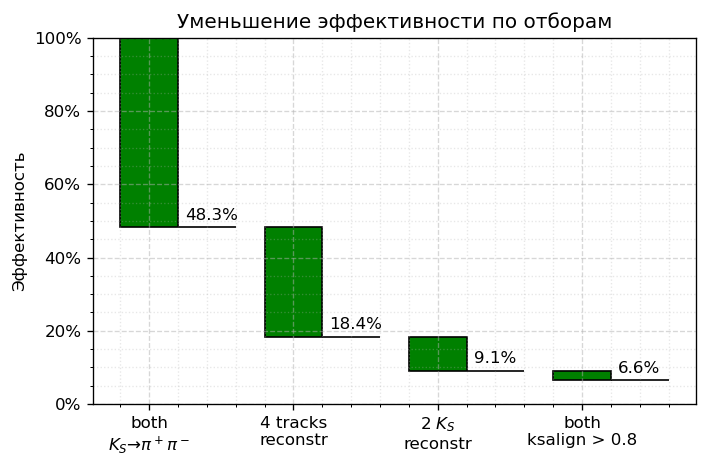

In [28]:
from matplotlib.ticker import PercentFormatter

selections = np.array([1, eff_kppc, eff_4t, eff_2ks, eff_align2])
sel_prod = np.cumprod(selections)

# fig, ax = plt.subplots()
plt.bar(np.arange(4), sel_prod[1:] - sel_prod[:-1], bottom = sel_prod[:-1], 
        color='green', width=0.4, label='1', edgecolor='black');
plt.bar(np.arange(4)+0.4, np.zeros(4), bottom = sel_prod[1:], 
        color='green', width=0.4, label='1', edgecolor='black');
for i, p in enumerate(sel_prod[1:]):
    plt.annotate(f'{p:.1%}', (i + 0.25, p+0.02))
plt.xticks(range(4), ['both\n$K_S \\to \pi^+\pi^-$', '4 tracks\nreconstr', 
                      '2 $K_S$\nreconstr', 'both\nksalign > 0.8'], rotation=0);
plt.gca().yaxis.set_major_formatter(PercentFormatter(1));
pys.my_style('–£–º–µ–Ω—å—à–µ–Ω–∏–µ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏ –ø–æ –æ—Ç–±–æ—Ä–∞–º',
             ytitle='–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å', ylim=(0, 1));

______

In [29]:
hmc = HandlerKSKS(tr_mc)
df_mc = hmc.get_good_kaons()
df_cut_mc = HandlerKSKS.collinear_cut(df_mc)
df_cut_mc = HandlerKSKS.sum_energy_cut(df_cut_mc)
df_cut_mc = HandlerKSKS.kaon_mom_cut(df_cut_mc)
df_cut_mc = HandlerKSKS.flight_cut(df_cut_mc)
df_cut_mc = HandlerKSKS.ksminv_cut(df_cut_mc)

In [30]:
eff_ksks0 = df_mc.index.droplevel(1).nunique()/len(tr_mc.arrays(['nt']))
print(f'–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å —Ä–µ–≥–∏—Å—Ç—Ä–∞—Ü–∏–∏ KSKS –¥–æ –¥–æ–ø. –æ—Ç–±–æ—Ä–æ–≤: {eff_ksks0:.2%}')

–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å —Ä–µ–≥–∏—Å—Ç—Ä–∞—Ü–∏–∏ KSKS –¥–æ –¥–æ–ø. –æ—Ç–±–æ—Ä–æ–≤: 4.03%


In [31]:
eff_ksks = df_cut_mc.index.droplevel(1).nunique()/len(tr_mc.arrays(['nt']))
print(f'–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å —Ä–µ–≥–∏—Å—Ç—Ä–∞—Ü–∏–∏ KSKS: {eff_ksks:.2%}')

–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å —Ä–µ–≥–∏—Å—Ç—Ä–∞—Ü–∏–∏ KSKS: 2.68%


## –°—Ä–∞–≤–Ω–∏–≤–∞—é —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –∏–∑ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏—è —ç—Ñ—Ñ–µ–∫—Ç–∞ –∏ —Ñ–æ–Ω–∞

–ù–∞ –∫–∞—Ä—Ç–∏–Ω–∫–∞—Ö –ø–æ–∫–∞–∑—ã–≤–∞—é **—Å—Ç—Ä–æ–≥–∏–µ** —É—Å–ª–æ–≤–∏—è –æ—Ç–±–æ—Ä–∞

In [32]:
file_mlt = '/store17/petrov/data/kskl20/tr_ph/multi/19/tr_ph_run053321.root'
tr_mlt = uproot.open(file_mlt)['tr_ph']
hmlt = HandlerKSKS(tr_mlt)
df_mlt = hmlt.get_good_kaons()

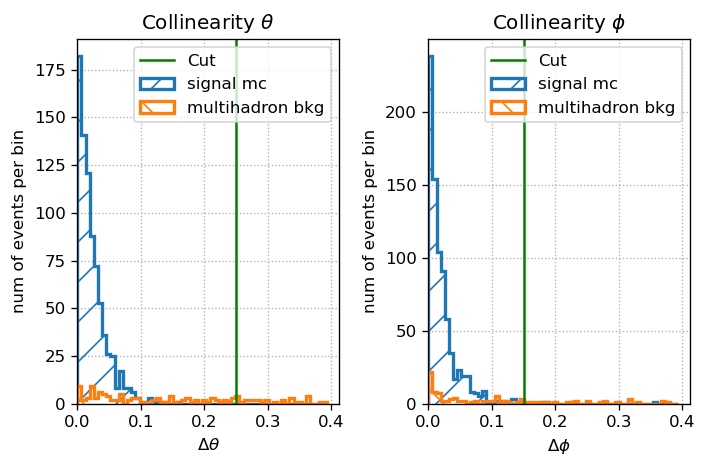

In [33]:
bins, rng, cut_th, cut_ph = 60, (0, np.pi/8), 0.25, 0.15
dtemp_mc = HandlerKSKS.collinear_cut(df_mc, return_pivot=True)
dtemp_mlt= HandlerKSKS.collinear_cut(df_mlt, return_pivot=True)

fig, ax = plt.subplots(1, 2)
ylabel = 'num of events per bin'
ax[0].hist(dtemp_mc[0], bins=bins, range=rng, label='signal mc',
          histtype='step', density=False, lw=2, hatch='/')
ax[0].hist(dtemp_mlt[0], bins=bins, range=rng, label='multihadron bkg',
          histtype='step', density=False, lw=2, hatch='\\')
ax[0].axvline(x=cut_th, ymin=0, ymax=1, color='green', label='Cut')
ax[0].set(xlim=(0, None), title='Collinearity $\\theta$',
         xlabel='$\\Delta\\theta$', ylabel=ylabel)
ax[1].hist(dtemp_mc[1], bins=bins, range=rng, label='signal mc',
          histtype='step', density=False, lw=2, hatch='/')
ax[1].hist(dtemp_mlt[1], bins=bins, range=rng, label='multihadron bkg',
          histtype='step', density=False, lw=2, hatch='\\')
ax[1].axvline(x=cut_ph, ymin=0, ymax=1, color='green', label='Cut')
ax[1].set(xlim=(0, None), title='Collinearity $\\phi$',
         xlabel='$\\Delta\\phi$', ylabel=ylabel)
for a in ax:
    a.grid(ls=':')
    a.legend()
plt.tight_layout()

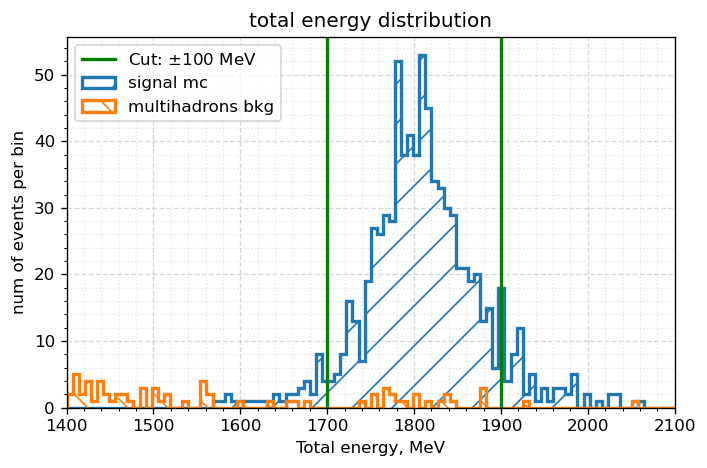

In [34]:
bins, rng, e0, dlt = 100, (1400, 2100), df_mc.emeas.mean()*2, 100
dtemp_mc = HandlerKSKS.sum_energy_cut(df_mc, return_pivot=True)
dtemp_mlt= HandlerKSKS.sum_energy_cut(df_mlt, return_pivot=True)

plt.hist(dtemp_mc, bins=bins, range=rng, hatch='/',
         label='signal mc', histtype='step', density=False, lw=2);
plt.hist(dtemp_mlt, bins=bins, range=rng, hatch='\\',
         label='multihadrons bkg', histtype='step', density=False, lw=2);
plt.axvline(e0 + dlt, 0, 1, color='green', label='Cut: $\pm 100$ MeV', lw=2)
plt.axvline(e0 - dlt, 0, 1, color='green', lw=2)
pys.my_style('total energy distribution', 'Total energy, MeV', 
             'num of events per bin', xlim=rng, legend=True);

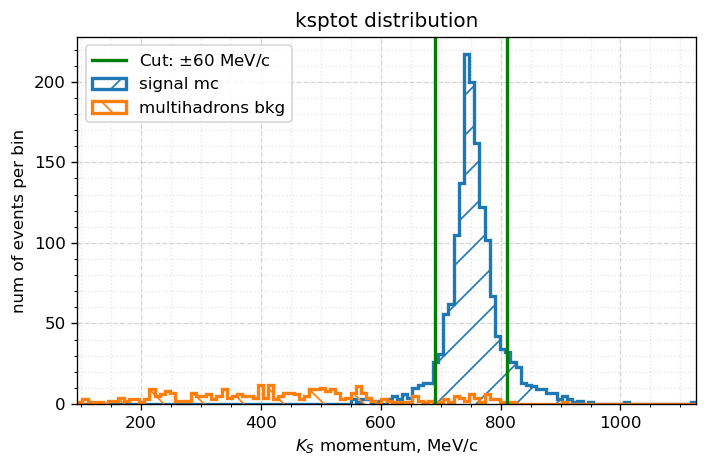

In [35]:
bins, rng = 120, (df_mlt.ksptot.min(), df_mc.ksptot.max())
plt.hist(df_mc.ksptot, bins=bins, range=rng, hatch='/',
         label='signal mc', histtype='step', density=False, lw=2);
plt.hist(df_mlt.ksptot, bins=bins, range=rng, hatch='\\',
         label='multihadrons bkg', histtype='step', density=False, lw=2);
p0 = np.sqrt(df_mc.emeas.mean()**2 - 497.6**2)
plt.axvline(p0 + 60, 0, 1, color='green', label='Cut: $\pm 60$ MeV/c', lw=2)
plt.axvline(p0 - 60, 0, 1, color='green', lw=2)
pys.my_style('ksptot distribution', '$K_S$ momentum, MeV/c', 
             'num of events per bin', xlim=rng, legend=True);

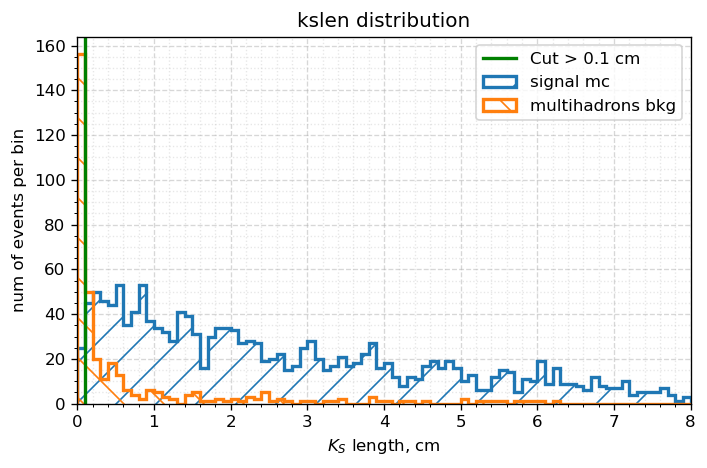

In [36]:
plt.hist(df_mc.kslen, bins=80, range=(0, 8), hatch='/',
         label='signal mc', histtype='step', density=False, lw=2);
plt.hist(df_mlt.kslen, bins=80, range=(0, 8), hatch='\\',
         label='multihadrons bkg', histtype='step', density=False, lw=2);
plt.axvline(0.1, 0, 1, color='green', label='Cut > 0.1 cm', lw=2)
pys.my_style('kslen distribution', '$K_S$ length, cm', 
             'num of events per bin', xlim=(0, 8), legend=True);

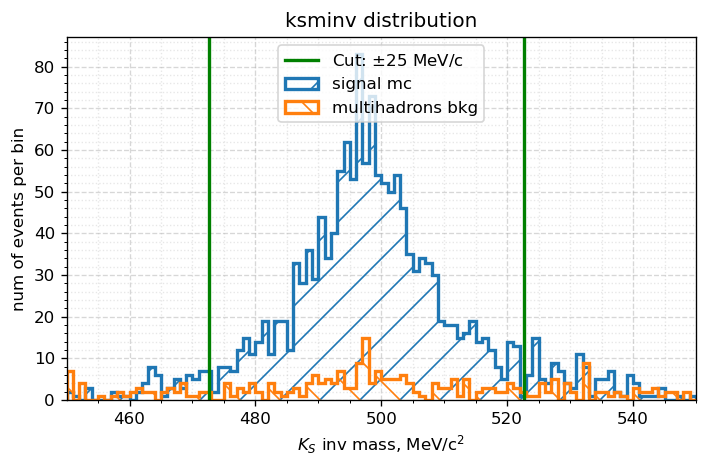

In [37]:
bins, rng, m0, dlt = 100, (450, 550), 497.6, 25
plt.hist(df_mc.ksminv, bins=bins, range=rng, hatch='/',
         label='signal mc', histtype='step', density=False, lw=2);
plt.hist(df_mlt.ksminv, bins=bins, range=rng, hatch='\\',
         label='multihadrons bkg', histtype='step', density=False, lw=2);
plt.axvline(m0 + dlt, 0, 1, color='green', label='Cut: $\pm 25$ MeV/c', lw=2)
plt.axvline(m0 - dlt, 0, 1, color='green', lw=2)
pys.my_style('ksminv distribution', '$K_S$ inv mass, MeV/c${}^2$', 
             'num of events per bin', xlim=rng, legend=True);

# Processing

–ë—É–¥—É –ø–æ—Å—Ç–µ–ø–µ–Ω–Ω–æ –∑–∞–∂–∏–º–∞—Ç—å –æ—Ç–±–æ—Ä—ã –∏ –ø—Ä–∏ —ç—Ç–æ–º —Å–º–æ—Ç—Ä–µ—Ç—å, –∫–∞–∫ —Å–æ–≥–ª–∞—Å—É–µ—Ç—Å—è –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–µ –∏ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç

–°–Ω–∞—á–∞–ª–∞ –ø–æ—Å–º–æ—Ç—Ä—é, —Å–∫–æ–ª—å–∫–æ –æ–∂–∏–¥–∞–µ—Ç—Å—è —Å–æ–±—ã—Ç–∏–π $e^+ e^- \to K_S K_S$ –Ω–∞ –≤—Å–µ–π —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–µ

In [38]:
def season_info(season):
    """
    –ü–æ–ª—É—á–∏—Ç—å –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ —Å–µ–∑–æ–Ω–µ –∏ pd.DataFrame —Å –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–µ–π –æ —Ç–æ—á–∫–∞—Ö
    """
    total_info_filename = f'../data/{season}/total_info_{season}.txt'
    total_info = pd.read_csv(total_info_filename, index_col=0)\
        .query('(emeas>545)&(emeas<955)')
    if season=='19':
        total_info = total_info.loc[total_info[['exp_tree', 'elabel', 'mlt_raw']].dropna().index]
    
    n_ksks_expected = \
    (np.interp(total_info['emeas'], df_fksks['ebeam'], df_fksks['cs_vis']) * eff_ksks * total_info['lum_exp']).sum()
    print(f'Season {season}')
    print(f'Energy range: ({total_info.emeas.min():.1f}; {total_info.emeas.max():.1f}) MeV')
    print(f'N(KSKS) expected = {n_ksks_expected:.4f} events')
    print(f'Integrated Lum = {total_info["lum_exp"].sum()*1e-3:.2f} pbn-1\n')
    
    return total_info

In [39]:
total_info = {}

total_info['12'] = season_info('12')
total_info['19'] = season_info('19')

Season 12
Energy range: (638.5; 951.6) MeV
N(KSKS) expected = 0.0084 events
Integrated Lum = 10.47 pbn-1

Season 19
Energy range: (549.3; 951.0) MeV
N(KSKS) expected = 0.0361 events
Integrated Lum = 49.40 pbn-1



–î–æ–≤–æ–ª—å–Ω–æ –º–∞–ª–æ —Å–æ–±—ã—Ç–∏–π –æ–∂–∏–¥–∞–µ—Ç—Å—è üò¢

–î–µ–ª–∞—é —Å–≤–æ–±–æ–¥–Ω—ã–µ –∫–∞—Ç—ã, —Å—Ä–∞–≤–Ω–∏–≤–∞—é –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–æ–±—ã—Ç–∏–π –≤ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–µ –∏ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–∏ —Ñ–æ–Ω–∞

–ü–æ–∏—Å–∫:
* *4 —Ö–æ—Ä–æ—à–∏—Ö —Ç—Ä–µ–∫–∞* –≤ —Å–æ–±—ã—Ç–∏–∏
* –≤ —Å–æ–±—ã—Ç–∏–∏ –µ—Å—Ç—å *2 –∫–∞–æ–Ω–∞*, –Ω–∞–π–¥–µ–Ω–Ω—ã—Ö –ø—Ä–æ—Ü–µ–¥—É—Ä–æ–π, –ø—Ä–∏—á—ë–º –æ–Ω–∏ —Å–æ—Å—Ç–∞–≤–ª–µ–Ω—ã –∏–∑ —Ö–æ—Ä–æ—à–∏—Ö —Ç—Ä–µ–∫–æ–≤
* –∫–∞–æ–Ω—ã –¥–æ–ª–∂–Ω—ã –∏–º–µ—Ç—å `ksalign > 0.8`
* —É—Å–ª–æ–≤–∏–µ –∫–æ–ª–ª–∏–Ω–µ–∞—Ä–Ω–æ—Å—Ç–∏ –∫–∞–æ–Ω–æ–≤: $f_{coll}(\phi) < 0.4$, $f_{coll}(\theta) < 0.4$
* $| E_{K_1} + E_{K_2} - 2 \cdot E_{beam} | < 250$ –ú—ç–í, $E_{K_i}$ - —ç–Ω–µ—Ä–≥–∏—è $i$-–≥–æ –∫–∞–æ–Ω–∞, –ú—ç–í; $E_{beam}$ - —ç–Ω–µ—Ä–≥–∏—è –ø—É—á–∫–∞, –ú—ç–í
* $| P_{K_i} - P_0 | < 120$ –ú—ç–í, —É—Å–ª–æ–≤–∏–µ –Ω–∞ –æ—Ç–ª–∏—á–∏–µ –∏–º–ø—É–ª—å—Å–æ–≤ –∫–∞–æ–Ω–æ–≤ ($P_{K_i}$) –æ—Ç –∏–¥–µ–∞–ª—å–Ω–æ–≥–æ –ø–æ –∫–∏–Ω–µ–º–∞—Ç–∏–∫–µ ($P_0 = \sqrt{E_{beam}^{2} - M_{K}^{2}}$)

In [40]:
from pylib.ksks import preprocess_point, process_point
df_proc = {}

In [41]:
def preprocess_season(total_info, season, force_process, print_log, plot):
    df = pd.DataFrame()
    for i, row in total_info.iterrows():
        dict_row = preprocess_point(row, df_4pic, 
                season=season, force_process=force_process, print_log=print_log)
        df = df.append(dict_row, ignore_index=True)
    if plot:
        plt.errorbar(df.emeas*2e-3, df.n_events, 
                 yerr=df.n_events_err, fmt='.', label='Expected')
        plt.errorbar(df.emeas*2e-3, df.real_events,
                     yerr=np.sqrt(df.real_events), fmt='.', label='Observed')
        pys.my_style('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –æ–∂–∏–¥–∞–µ–º–æ–≥–æ —Ñ–æ–Ω–∞ –∏ –Ω–∞–±–ª—é–¥–∞–µ–º–æ–µ\n–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–æ–±—ã—Ç–∏–π –¥–ª—è —Å–ª–∞–±—ã—Ö –æ—Ç–±–æ—Ä–æ–≤', 
                     xtitle='$\sqrt{s}$, GeV', ytitle='num of events',
            legend=True, ylim=(0, None), xlim=(None, None))
    return df

–û–±—Ä–∞–±–æ—Ç–∫–∞ —Å–µ–∑–æ–Ω–∞ `12`

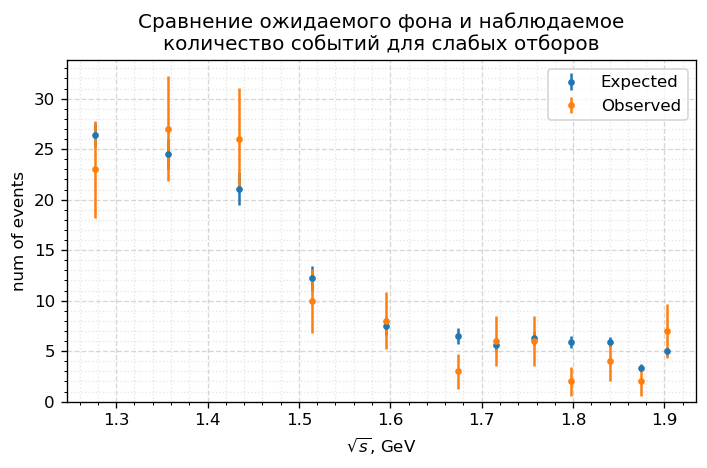

In [42]:
season = '12'
df_proc[season] = preprocess_season(total_info[season], season, False, False, True)

–û–±—Ä–∞–±–æ—Ç–∫–∞ —Å–µ–∑–æ–Ω–∞ `19`

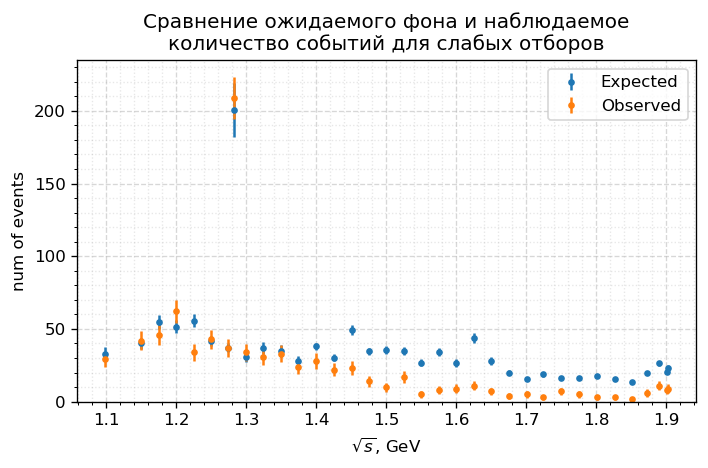

In [43]:
season = '19'
df_proc[season] = preprocess_season(total_info[season], season, False, False, True)

–í —Å–µ–∑–æ–Ω–µ `19` –æ–∂–∏–¥–∞–µ–º–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–æ–±—ã—Ç–∏–π –Ω–µ —Å–æ–≥–ª–∞—Å—É–µ—Ç—Å—è —Å –Ω–∞–±–ª—é–¥–∞–µ–º—ã–º, –ø—Ä–∏—á—ë–º –æ–∂–∏–¥–∞–µ–º—ã—Ö —Å–æ–±—ã—Ç–∏–π –±–æ–ª—å—à–µ, –ø–æ—ç—Ç–æ–º—É —Ç–∞–∫—É—é —Ä–∞–∑–Ω–∏—Ü—É –Ω–µ–ª—å–∑—è —Å–≤—è–∑–∞—Ç—å —Å –Ω–µ—É—á—Ç—ë–Ω–Ω—ã–º —Ñ–æ–Ω–æ–≤—ã–º –ø—Ä–æ—Ü–µ—Å—Å–æ–º

In [44]:
from matplotlib.ticker import PercentFormatter
dtemp = df_proc['19']
plt.errorbar( dtemp.emeas*2e-3, dtemp.part_4pic, 
             yerr=dtemp.part_4pic_err, fmt='.')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) 
pys.my_style('–í–∫–ª–∞–¥ $e^+e^- \\to \ 2\pi^+2\pi^-$ –≤ –æ–±—â–∏–π —Ñ–æ–Ω', 
             xtitle='$\sqrt{s}$, GeV',
             ytitle='–î–æ–ª—è $2\pi^+2\pi^-$', ylim=(0, 1))

–í –¥–∞–ª—å–Ω–µ–π—à–µ–º, –¥–ª—è —É–ª—É—á—à–µ–Ω–∏—è —Ç–æ—á–Ω–æ—Å—Ç–∏, –º–æ–∂–Ω–æ –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å —É—á–µ—Å—Ç—å –¥—Ä—É–≥–∏–µ —Ñ–æ–Ω–æ–≤—ã–µ –ø—Ä–æ—Ü–µ—Å—Å—ã (—Ö–æ—Ç—è –≤–µ—Ä–æ—Ç–Ω–æ—Å—Ç—å, —á—Ç–æ –æ–Ω–∏ –≤—ã–∂–∏–≤—É—Ç –≤ —Å—Ç—Ä–æ–≥–∏—Ö –∫–∞—Ç–∞—Ö, –º–∞–ª–∞)

–£—Å–∏–ª–∏–≤–∞—é –∫–∞—Ç—ã

In [45]:
def process_season(total_info, season, print_log, plot):
    df = pd.DataFrame()
    for i, row in total_info.iterrows():
        dict_row = process_point(row, df_4pic, 
                season=season, print_log=print_log)
        df = df.append(dict_row, ignore_index=True)
    df = df.set_index('elabel')
    df = df.join(total_info[['elabel', 'lum_exp']].set_index('elabel'))
    if plot:
        plt.errorbar(df.emeas*2e-3, df.n_events, 
                 yerr=df.n_events_err, fmt='.', label='Expected')
        plt.errorbar(df.emeas*2e-3, df.real_events,
                     yerr=np.sqrt(df.real_events), fmt='.', label='Observed')
        pys.my_style('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –æ–∂–∏–¥–∞–µ–º–æ–≥–æ —Ñ–æ–Ω–∞ –∏ –Ω–∞–±–ª—é–¥–∞–µ–º–æ–µ\n–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–æ–±—ã—Ç–∏–π', 
                     xtitle='$\sqrt{s}$, GeV', ytitle='num of events',
            legend=True, ylim=(0, None), xlim=(None, None))
    return df

In [46]:
df_events = pd.DataFrame()
df_events = df_events.append(process_season(total_info['12'], '12', False, False))
df_events = df_events.append(process_season(total_info['19'], '19', False, False))

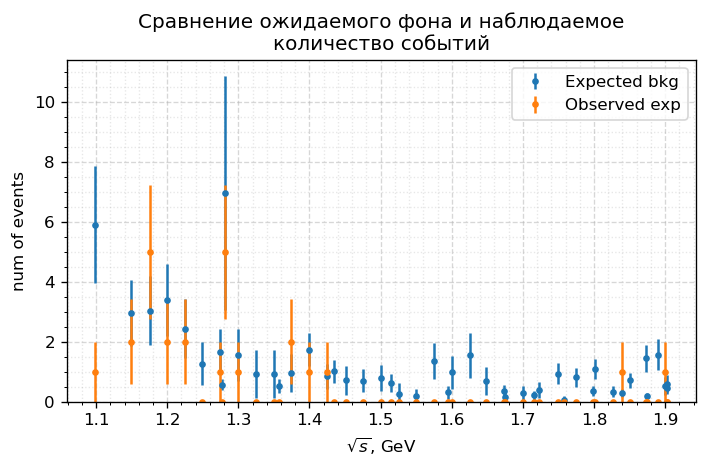

In [47]:
plt.errorbar(df_events.emeas*2e-3, df_events.n_events,
            yerr=df_events.n_events_err, fmt='.', label='Expected bkg')
plt.errorbar(df_events.emeas*2e-3, df_events.real_events,
            yerr=np.sqrt(df_events.real_events), fmt='.', label='Observed exp')
pys.my_style('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –æ–∂–∏–¥–∞–µ–º–æ–≥–æ —Ñ–æ–Ω–∞ –∏ –Ω–∞–±–ª—é–¥–∞–µ–º–æ–µ\n–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–æ–±—ã—Ç–∏–π', 
             xtitle='$\sqrt{s}$, GeV', ytitle='num of events',
    legend=True, ylim=(0, None), xlim=(None, None))

–î–æ–±–∞–≤–ª—è—é –ø–æ–ª–µ —Å –æ–∂–∏–¥–∞–µ–º—ã–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —Å–∏–≥–Ω–∞–ª–∞ (`n_sig`) –≤ —É–Ω–∏—Ç–∞—Ä–Ω–æ–º –ø—Ä–µ–¥–µ–ª–µ –≤ `df_events`. 

In [48]:
df_events['cs_born'] = born_ee_f((df_events.emeas*2e-3)**2)
df_events['cs_vis'] = born2visible(df_events['emeas'], 
                                   df_events['cs_born'], threshold=497.6)
df_events['n_sig'] = df_events['cs_vis'] * df_events['lum_exp'] * eff_ksks

–°—Ç—Ä–æ—é –ª–∞–π–∫–ª–∏—Ö—É–¥ –∏ —Å –ø–æ–º–æ—â—å—é `minuit` –≤—ã—á–∏—Å–ª—è—é –∏–Ω—Ç–µ—Ä–≤–∞–ª

In [49]:
from scipy.stats import poisson
from scipy.stats import norm

In [50]:
def cost_function(Br=[0] + [0]*len(df_events)):
    """
    –õ–∞–π–∫–ª–∏—Ö—É–¥
    """
    nb = np.array(Br[1:])
    eff = (df_events.n_events_err**2)/df_events.n_events
    f = -np.sum(
        np.log(
            poisson.pmf(df_events.real_events, df_events.n_sig*Br[0] + nb)
        )
        +np.log(
            norm.pdf(df_events.n_events, nb, np.sqrt(eff*nb))
        )
    )
    return f

In [51]:
a = [1] + df_events.n_events.tolist()

In [52]:
m = iminuit.minuit.Minuit(cost_function, np.array(a))
m.errordef = iminuit.minuit.Minuit.LIKELIHOOD
for i in range(len(a)):
    m.limits[f'x{i}'] = (0, None)

In [53]:
m.simplex().migrad()#.minos(cl=0.9);
m.valid

/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


True

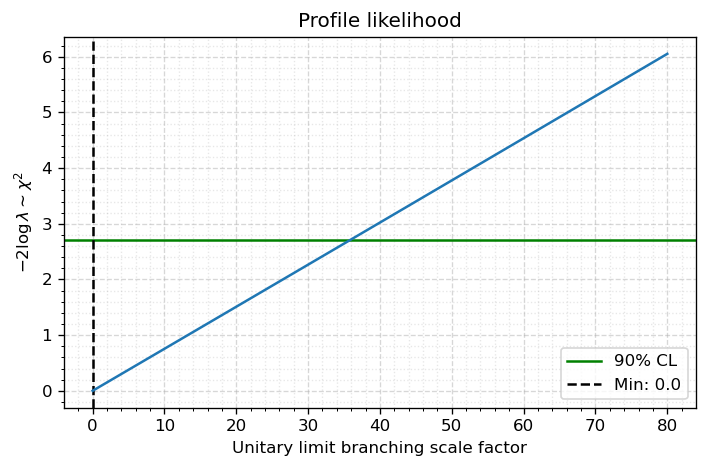

In [54]:
tx, ty, _ = m.mnprofile('x0', bound=(1e-6, 80), subtract_min=True)
ty*=2
plt.axhline(2.706, 0, 1, c='g', label='90% CL')
plt.axvline(tx[np.argmin(ty)], 0, 1, c='black', ls='--', 
            label=f'Min: {tx[np.argmin(ty)]:.1f}')
plt.plot(tx, ty);
pys.my_style('Profile likelihood', 'Unitary limit branching scale factor', 
             '$-2\log{\lambda} \sim \chi^2$', legend=True);

–ù–∞ –∫–∞—Ä—Ç–∏–Ω–∫–µ –ø–æ–∫–∞–∑–∞–Ω *profile likelihood*. –ü–æ –æ—Å–∏ `x` –ø–æ–∫–∞–∑–∞–Ω —Ñ–∏—Ç–∏—Ä—É–µ–º—ã–π –ø–∞—Ä–∞–º–µ—Ç—Ä - –º–∞—Å—à—Ç–∞–±, —Ç.–µ. –≤–æ —Å–∫–æ–ª—å–∫–æ —Ä–∞–∑ –Ω–∞–±–ª—é–¥–∞–µ–º–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–æ–±—ã—Ç–∏–π —Å–∏–≥–Ω–∞–ª–∞ –±–æ–ª—å—à–µ –æ–∂–∏–¥–∞–µ–º–æ–≥–æ –≤ —É–Ω–∏—Ç–∞—Ä–Ω–æ–º –ø—Ä–µ–¥–µ–ª–µ.

–¢.–∫. *profile likelihood* ~ $\chi^2(1)$, —Ç–æ –∏–Ω—Ç–µ—Ä–≤–∞–ª –¥–æ–≤–µ—Ä–∏—è 90% —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É–µ—Ç –∑–Ω–∞—á–µ–Ω–∏—é 2.703

–ü–µ—Ä–µ–≤–æ–∂—É –º–∞—Å—à—Ç–∞–±–Ω—ã–π –ø–∞—Ä–∞–º–µ—Ç—Ä –≤ –±—Ä–∞–Ω—á–∏–Ω–≥, –ø–æ–∫–∞–∑—ã–≤–∞—é —Ä–µ–∑—É–ª—å—Ç–∞—Ç:

In [55]:
cl90 = np.interp(2.706, ty, tx)
print(f'Br < {(cl90*Br_ee_unitary_limit):.2e} at 90% CL')

Br < 8.05e-10 at 90% CL


# –ò—Å—Ç–æ—á–Ω–∏–∫–∏

1. [$f_2^{'}(1525)$ PDG](https://pdglive.lbl.gov/Particle.action?init=0&node=M013&home=MXXX005)

## –°—Ç–∞—Ç—å–∏

1. [BaBar, $e^+e^- \to \pi^+\pi^-\pi^+\pi^-$](https://arxiv.org/pdf/1201.5677.pdf)
1. [Limits and Confidence Intervals in the Presence of Nuisance Parameters](https://arxiv.org/pdf/physics/0403059.pdf)
1. [A Unified Approach to the Classical Statistical Analysis of Small Signals](https://arxiv.org/pdf/physics/9711021.pdf)